# Importing Libraries

In [48]:
# data mainipulation
import pandas as pd

# Database I/O
import sqlite3

# for some data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Getting data from the internet
import requests

Let's create a function to get data from our database

In [11]:
def get_sqlite_connection():
    database_path = 'data/database/citibike_data.db'
    return sqlite3.connect(database_path)

def sqlite_select_query(sql_query):
    with get_sqlite_connection() as connection:
        return pd.read_sql_query(sql_query, connection)

def table_exists(table_name):
    with get_sqlite_connection() as connection:
        cursor = connection.cursor()
        cursor.execute(
            f"Select name from sqlite_master where type ='table'"
        )
        return cursor.fetchone() is not None

In [19]:
# Let's get a dataset of daily rides
daily_rides_df = sqlite_select_query(
    "select strftime('%Y-%m-%d', trip_start_at) as trip_start_date, sum(ride_count) as daily_rides FROM ride_counts_by_hour group by 1"
)

daily_rides_df['trip_start_date'] = pd.to_datetime(daily_rides_df['trip_start_date'])

daily_rides_df.head()

,trip_start_date,daily_rides
0,2013-06-01,8722
1,2013-06-02,15971
2,2013-06-03,7598
3,2013-06-04,15782
4,2013-06-05,15690


In [30]:
# Just in case, let's create a week field

daily_rides_df['week_ending_monday'] = daily_rides_df['trip_start_date'] + pd.to_timedelta((6 - daily_rides_df['trip_start_date'].dt.dayofweek) % 7 + 1, unit='D')

daily_rides_df

,trip_start_date,daily_rides,week_ending_monday
0,2013-06-01,8722,2013-06-03
1,2013-06-02,15971,2013-06-03
2,2013-06-03,7598,2013-06-10
3,2013-06-04,15782,2013-06-10
4,2013-06-05,15690,2013-06-10
...,...,...,...
3821,2023-11-26,46249,2023-11-27
3822,2023-11-27,89180,2023-12-04
3823,2023-11-28,82936,2023-12-04
3824,2023-11-29,83511,2023-12-04


Let's see the weekly rides plotted

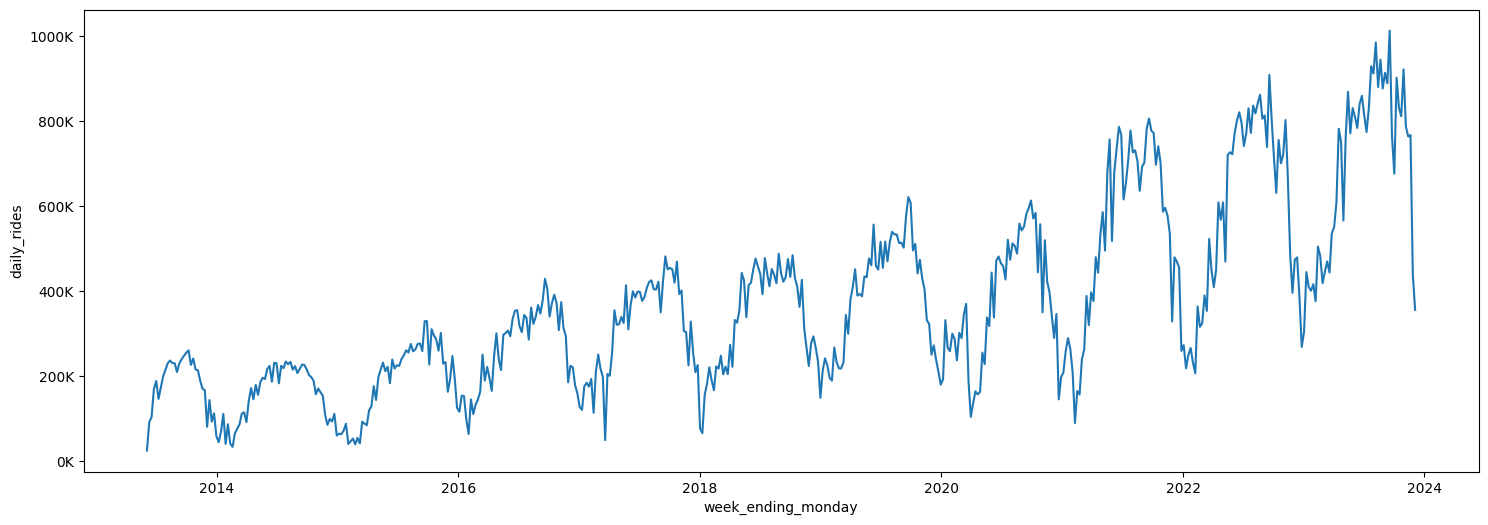

In [41]:
weekly_rides = daily_rides_df[['week_ending_monday','daily_rides']].groupby('week_ending_monday').sum().reset_index()
# Make the figure larger
plt.figure(figsize=(18, 6))

# Create a line plot
sns.lineplot(
    x = 'week_ending_monday'
    , y = 'daily_rides'
    , data = weekly_rides
)

# This changes the y Axis so we get it in thousands
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}K'.format(x / 1000)))

plt.show()


In [43]:
weekly_rides.describe()

,week_ending_monday,daily_rides
count,549,5.490000e+02
mean,2018-09-03 00:00:00,3.711395e+05
min,2013-06-03 00:00:00,2.469300e+04
25%,2016-01-18 00:00:00,2.140520e+05
50%,2018-09-03 00:00:00,3.247840e+05
75%,2021-04-19 00:00:00,4.766240e+05
max,2023-12-04 00:00:00,1.012506e+06
std,NaN,2.179567e+05


# Let's see what's correlated with ridership.
## First off, weather.
We're going to use the [Visual Crossing](https://www.visualcrossing.com/) API

The NYC location is (40.730610, -73.935242)

In [55]:
zip_code = 10019

weather_response = []

for each_year in range(2013,2024):
    weather_url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{zip_code}/{each_year}-01-01/{each_year+1}-12-31?unitGroup=metric&include=days&key=VB7HFK3G76F5DQ6VK9BYUKRY2&contentType=json"
    weather_response.append(
        requests.get(weather_url)
    )
    break